In [48]:
# date: 2020/5/24
# author: zonnoz
# description: 热门时段
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from tqdm import tqdm
from IPython.core.pylabtools import figsize
import warnings


warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = (16.0, 8.0)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option("display.precision", 16)

sns.set_style('ticks') #加上刻度

Debug = False
nrows = 10000 if Debug else None # 数据范围
bins = 100 if Debug else 1000 # 分桶

In [5]:
train_path = "./data/underexpose_train"
test_path = "./data/underexpose_test"

train_path_feat = train_path + "/underexpose_user_feat.csv"
train_path_click = train_path + "/underexpose_train_click-{0}.csv"
test_path_click = test_path + "/underexpose_test_click/underexpose_test_click-{0}.csv"
test_path_qtime = test_path + "/underexpose_test_qtime/underexpose_test_qtime-{0}.csv"

In [46]:
def get_train_click(list_train_click_file):
    """ 获取训练集的点击数据
    :param list_train_click_file:
    :return:
    """
    list_underexpose_click = []
    columns = ["user_id", "item_id", "time", "phase"]
    for phase, file in tqdm(list_train_click_file):
        underexpose_click = pd.read_csv(file,
                                        names=["user_id", "item_id", "time"],
                                        nrows=nrows,
                                        # dtype={"user_id": int, "item_id": int, "time": float},
                                        sep=","
                                        )
        underexpose_click.drop_duplicates(inplace=True)
        underexpose_click["phase"] = phase
        underexpose_click = underexpose_click[columns]
        list_underexpose_click.append(underexpose_click)

    all_underexpose_click = pd.concat(list_underexpose_click)
    all_underexpose_click["category"] = "train"
    return all_underexpose_click


def get_test_click(list_test_phase_file, list_test_phase_query_file):
    """ 测试集合并（click + qtime）
    :param list_test_phase_file:
    :param list_test_phase_query_file:
    :return:
    """
    list_underexpose_click = []
    columns = ["user_id", "item_id", "time", "phase", "category"]
    for phase, file in tqdm(list_test_phase_file):  # 测试集
        underexpose_click = pd.read_csv(file,
                                        names=["user_id", "item_id", "time"],
                                        nrows=nrows,
                                        sep=","
                                        )
        underexpose_click.drop_duplicates(inplace=True)
        underexpose_click["phase"] = phase
        underexpose_click["category"] = "test"
        underexpose_click = underexpose_click[columns]
        list_underexpose_click.append(underexpose_click)

    for phase, file in tqdm(list_test_phase_query_file):
        underexpose_qtime = pd.read_csv(file
                                        , names=["user_id", "query_time"]
                                        , nrows=nrows
                                        , sep=","
                                        )
        underexpose_qtime.drop_duplicates(inplace=True)
        underexpose_qtime.columns = ["user_id", "time"]
        underexpose_qtime["phase"] = phase
        underexpose_qtime["item_id"] = -999  # 预测集标记
        underexpose_qtime["category"] = "predict" # 预测集标记
        underexpose_qtime = underexpose_qtime[columns]
        list_underexpose_click.append(underexpose_qtime)

    all_underexpose_click = pd.concat(list_underexpose_click)

    return all_underexpose_click[columns]


def show_popular_time_per_phase(T: int, lines = []):
    phases = [T]
    # 每个T应该包含train & test 去重
    underexpose_train_click = get_train_click([(x, train_path_click.format(x)) for x in phases])
    underexpose_test_click = get_test_click([(x, test_path_click.format(x)) for x in phases],
                                            [(x, test_path_qtime.format(x)) for x in phases])
    underexpose_test_click = underexpose_test_click[underexpose_test_click["category"] == "test"]
    
    # 对完整的某 T 做时间分布
    cols = ["user_id", "item_id", "time"]
    data = pd.concat([underexpose_train_click[cols], underexpose_test_click[cols]])
    data.drop_duplicates(inplace=True) # 再次去重，避免测试集与训练集有重复

    sns.distplot(data["time"], bins=bins) # 默认分桶50，建议1000 or 10000
    plt.legend(["T-{0}".format(T)])
    plt.xticks(rotation=60)
    ax=plt.gca()
    x_major_locator=MultipleLocator(0.00001) # 可观测的最小刻度
    ax.xaxis.set_major_locator(x_major_locator)
    
    if lines:
        for line in lines:
            plt.vlines(line, 0, 6000, 'r', '--', label='line')
#     sns.scatterplot([0.983755, 0.983800, 0.983810, 0.983855, 0.983865, 0.983906, 0.983920, 0.983957], [2800]*8, 
#                     palette=['green','orange','brown','dodgerblue','red', 'green','orange','brown'])
#     plt.plot([0.983755, 0.983800, 0.983810, 0.983855, 0.983865, 0.983906, 0.983920, 0.383957], [2800]*8)
    plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 66.85it/s]


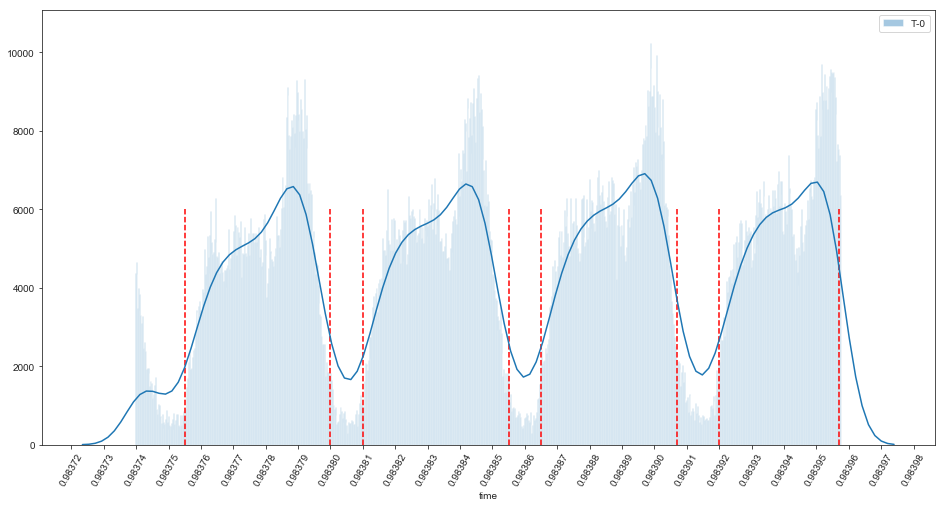

In [72]:
lines = [0.983755, 0.983800, 0.983810, 0.983855, 0.983865, 0.983907, 0.983920, 0.983957]
show_popular_time_per_phase(0, lines)

[(0.983755, 0.983800), (0.983810, 0.983855), (0.983865, 0.983906), (0.983920, 0.0.383957)]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 66.59it/s]


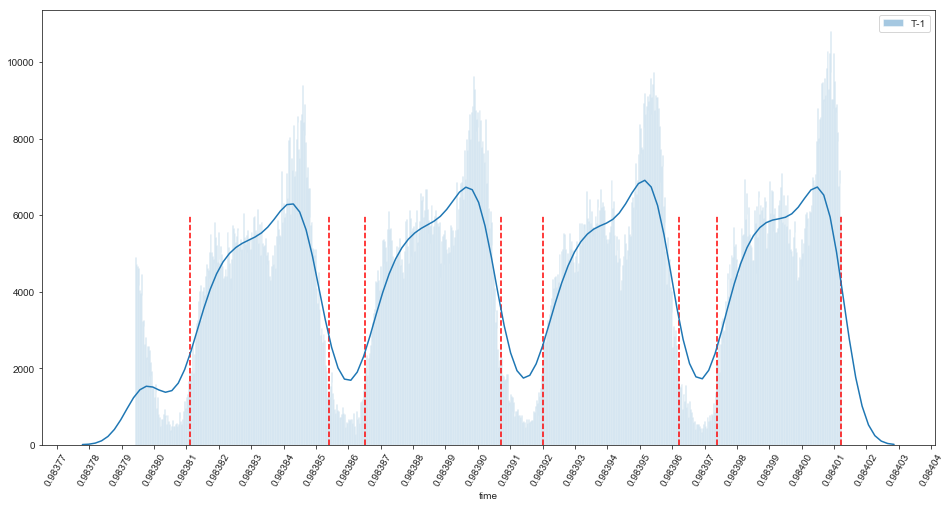

In [73]:
lines = [0.983811, 0.983854, 0.983865, 0.983907, 0.983920, 0.983962, 0.983974, 0.984012]
show_popular_time_per_phase(1, lines)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.27it/s]


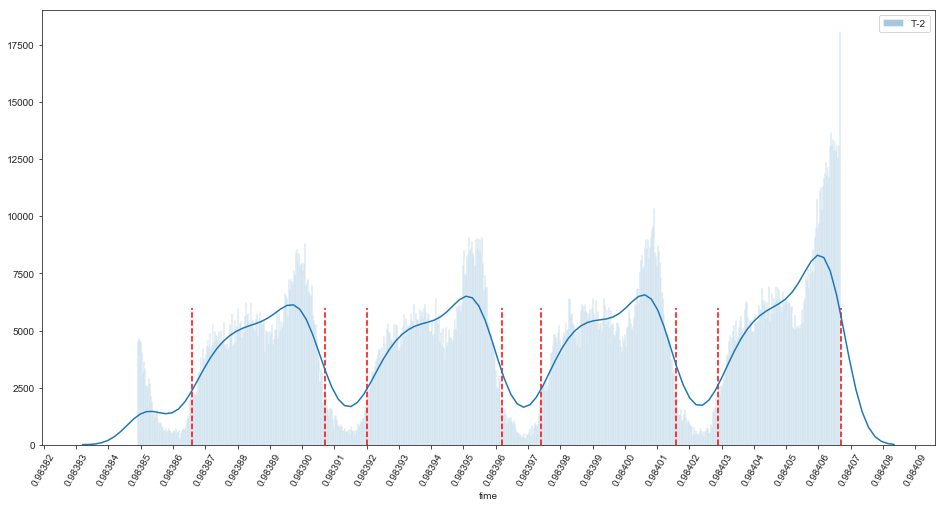

In [83]:
lines = [0.983866, 0.983907, 0.983920, 0.983962, 0.983974, 0.984016, 0.984029, 0.984067]
show_popular_time_per_phase(2, lines=lines)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 125.36it/s]


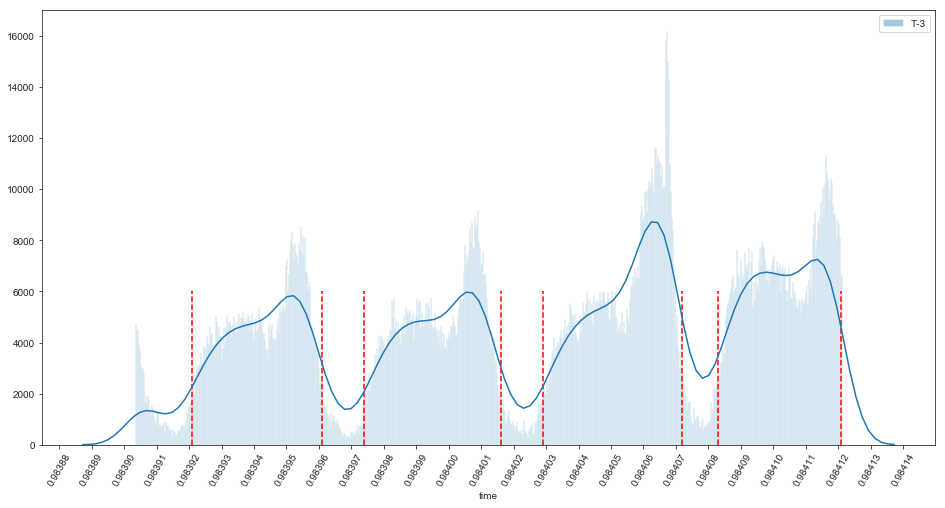

In [60]:
lines = [0.983921, 0.983961, 0.983974, 0.984016, 0.984029, 0.984072, 0.984083, 0.984121]
show_popular_time_per_phase(3, lines=lines)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 111.40it/s]


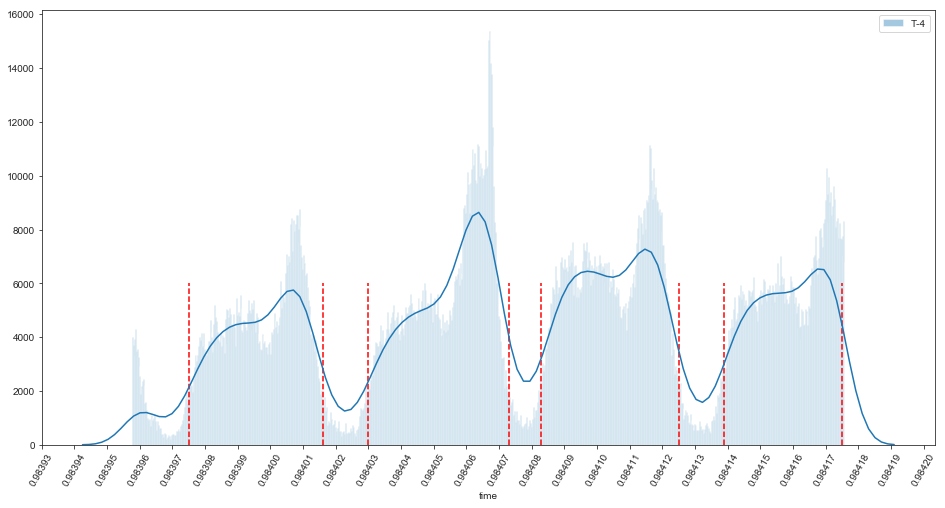

In [67]:
lines = [0.983975, 0.984016, 0.984030, 0.984073, 0.984083, 0.984125, 0.984139, 0.984175]
show_popular_time_per_phase(4, lines=lines)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 131.36it/s]


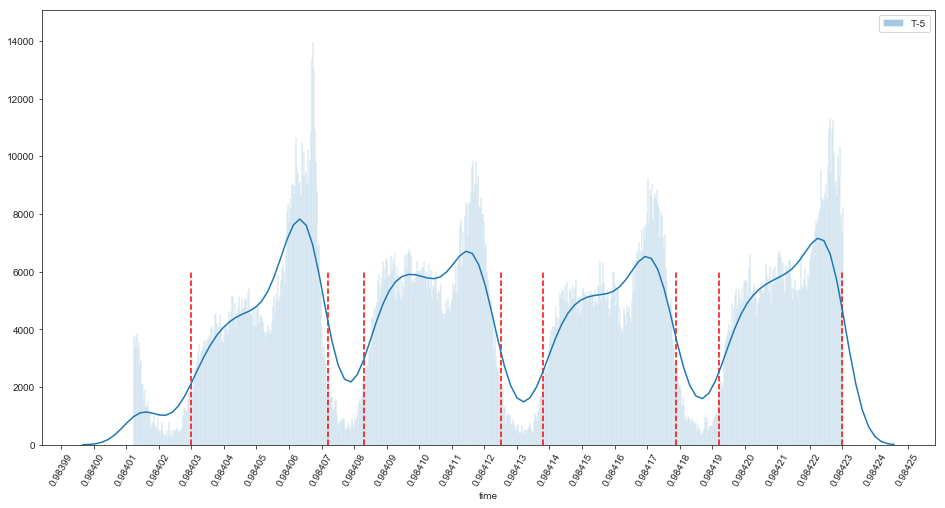

In [71]:
lines = [0.984030, 0.984072, 0.984083, 0.984125, 0.984138, 0.984179, 0.984192, 0.984230]
show_popular_time_per_phase(5, lines=lines)